# CommentNet-V3 

Welcome to the version 3 of CommentNet!

First let's import the relevant packages.


In [ ]:
import csv
import string
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Concatenate, Dot, RepeatVector
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import keras.backend as K
import coremltools
import matplotlib.pyplot as plt

# Preparing the data

Next, let's process the data set.

We will process the data set and create a new data set by removing punctuation and trimming the lines in the data set.

In [ ]:
def process_data(file_list_with_labels, output='../data/data_set.txt', output_label = '../data/labels.txt'):
    phrase = []
    emoji = []

    with open (output, 'w') as output_file, open(output_label, 'w') as label_file:
        
        for filename, label in file_list_with_labels:
            print('Processing file: ', filename)
            with open (filename) as f:
                  for line in f:
                    line = line.strip()
                    if len(line)>0:
                        table = str.maketrans({key: None for key in string.punctuation})
                        line = line.translate(table)
                        output_file.write(line + '\r\n')
                        label_file.write(label + '\r\n')
                        phrase.append(0)
    

Our data set files are in 3 separate sets of files.

- troll data set and it's labels
- constructive data set and it's labels
- positive data set and it's labels

We will process these 3 separate data sets and create one combined dataset and label set.

In [ ]:
file_list_with_labels = []
file_list_with_labels.append(('../data/troll.txt', '1'))
file_list_with_labels.append(('../data/constructive.txt', '0'))
file_list_with_labels.append(('../data/positive.txt', '0'))
process_data(file_list_with_labels)

Next, it's time to load the GloVe word embedding files.

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f, open('../data/glove_word_index.txt', 'w') as word_index_file:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        word_index = []
        for w in sorted(words):
            word_index.append(w + ' ' + str(i))
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
        
        for line in word_index:
            word_index_file.write(line + '\n')
    return words_to_index, index_to_words, word_to_vec_map, i

In [ ]:
word_to_index, index_to_word, word_to_vec_map, unknown_word_index = read_glove_vecs('../../../CommentNetData/glove.6B/glove.6B.50d.txt')

Next, we will also read in a custom word embedding to be used for unkown word tokens.

In [ ]:
def read_unknown_vecs(unknown_file):
    
    unknown_vector = None
    
    with open(unknown_file, 'r') as f:
        for line in f:
            line = line.strip().split()
            unknown_vector = np.array(line[0:], dtype=np.float64)
    
    print('Unknown word vector is', unknown_vector.shape)

    return unknown_vector

In [ ]:
unkown_word_vector = read_unknown_vecs('../data/unknown_word_vector.txt')

In [ ]:
word = "ea"
index = 18
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])
print(unknown_word_index)
print(word_to_vec_map[word].reshape(1, -1).shape)
cosine_similarity(word_to_vec_map["bethesda"].reshape(1, -1), word_to_vec_map["ea"].reshape(1, -1))

Now, let's load the data set and label set we processed in the previous cell.

In [ ]:
def read_processed_data(data_set = '../data/data_set.txt', labels = '../data/labels.txt'):
    
    X = []
    Y = []
    
    with open(data_set) as data_file:
        for line in data_file:
            line = line.strip()
            if len(line) > 0:
                X.append(line)
    
    with open(labels) as label_file:
        for line in label_file:
            line = line.strip()
            if len(line) > 0:
                Y.append(line)
                
    X = np.asarray(X)
    Y = np.asarray(Y, dtype=int)
    
    return X, Y
    

In [ ]:
X, Y = read_processed_data()

In [ ]:
print('X : ', len(X))
print('Y : ', len(Y))

Let's shuffle the data set to mix the positive and negative examples.

In [ ]:
X, Y = shuffle(X, Y, random_state=0)
print(X[len(X) - 1], Y[len(Y) - 1])

Next, we need to find the maximum word count in a sentence in the data set. This value will be used for the masking operation in creating the word indices and will be used to determine the number of time steps in the model.

In [ ]:
def find_max_len(X):
    
    max_len = 0
    max_line = None
    max_array = []
    
    
    for line in X:
        sentence_words =line.lower().split()
        if len(sentence_words) > max_len:
            max_len = len(sentence_words)
            max_line = line 
            max_array = sentence_words
    
    print ('Max length is ', max_len)
    print(max_line)
    print(max_array)
    
    return max_len

In [ ]:
max_len = find_max_len(X)
Tx = max_len

In [ ]:
def create_train_dev_test(X, Y, split):
    
    X, Y = shuffle(X, Y)
    
    mode = split[0]
    
    if mode == 'tt':
        train_size, test_size = split[1]
        
        X_train = X[:train_size]
        Y_train = Y[:train_size]
    
        X_test = X[train_size:]
        Y_test = Y[train_size:]
        
        print('Size of test set : ', len(X_train))
        print('Size of train set : ', len(X_test))
    
        result = (X_train, Y_train, X_test, Y_test)
        
    else:
        
        train_size, dev_size, test_size = split[1]
        
        X_train = X[:train_size]
        Y_train = Y[:train_size]
    
        X_dev = X[train_size:train_size + dev_size]
        Y_dev = Y[train_size:train_size + dev_size]
    
        X_test = X[train_size + dev_size:]
        Y_test = Y[train_size + dev_size:]
        
        print('Size of test set : ', len(X_train))
        print('Size of dev set : ', len(X_dev))
        print('Size of train set : ', len(X_test))
    
        result = (X_train, Y_train, X_dev, Y_dev, X_test, Y_test)

    
    return result
    

In [ ]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = create_train_dev_test(X, Y, ['tvt', (100, 25, 25)])

In [ ]:
print(X_train[len(X_train) - 1], Y_train[len(Y_train) - 1])

In [ ]:
X_train, Y_train, X_test, Y_test = create_train_dev_test(X, Y, ['tt', (100, 50)])

In [ ]:
print(Y_train.shape)

# Creating the Model

Now, let's define the function to turn the sentences of the data set into word indices.

In [ ]:
def sentences_to_indices(X, word_to_index, max_len, unknown_word_index):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j = j + 1
            else:
                X_indices[i, j] = unknown_word_index
                j = j + 1
            
    ### END CODE HERE ###
    
    return X_indices

We also need to feed our pre-trained word encodings into the Keras embedding layer. This function will take care of that.

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, unkown_word_vector, unknown_word_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = unknown_word_index + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    
    emb_matrix[unknown_word_index, :] = unkown_word_vector

    # Define Keras embedding layer with the correct output/input sizes, make it non-trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

Define custom softmax function to be used in the Attention mechanism's alpha calculation step.

In [ ]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

Define global variables for the attention step

In [ ]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are nor using the custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

The function to calculate the context for the each step in the final Bi-LSTM layer

In [ ]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

Now that we have all the necessary parts, let's create the model.

In [ ]:
def CommentNet(input_shape, word_to_vec_map, word_to_index, unkown_word_vector, unknown_word_index):
    """
    Function creatiDabareng the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, unkown_word_vector, unknown_word_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    a = Bidirectional(LSTM(128, return_sequences = True), merge_mode = 'ave')(embeddings)
    # Add dropout with a probability of 0.5
    #X = Dropout(rate = 0.5)(X)
    
    s0 = Input(shape=(128,), name='s0')
    c0 = Input(shape=(128,), name='c0')
    s = s0
    c = c0
    
    post_attention_Bi_LSTM_cell = LSTM(128, return_state = True)
    
    for t in range(Tx):
        
        context = one_step_attention(a, s)
        
        s, _, c = post_attention_Bi_LSTM_cell(context, initial_state = [s, c])
        
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(s)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(1, activation='sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = [sentence_indices, s0, c0], outputs = X)
    
    ### END CODE HERE ###
    
    return model

In [ ]:
model = CommentNet((max_len,), word_to_vec_map, word_to_index, unkown_word_vector, unknown_word_index)

In [81]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 54, 50)       20000100    input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 128)          0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 54, 128)      183296      embedding_1[0][0]                
__________________________________________________________________________________________________
repeat_vec

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len, unknown_word_index)

In [ ]:
train_index = 60
print(X_train.shape[0])
print(X_train[train_index])
print(X_train_indices[train_index])

In [ ]:
s0 = np.zeros((X_train.shape[0], 128))
c0 = np.zeros((X_train.shape[0], 128))

In [ ]:
model.fit([X_train_indices, s0, c0], Y_train, epochs = 50, batch_size = 32, shuffle=True)

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len, unknown_word_index)
s0 = np.zeros((X_test_indices.shape[0], 128))
c0 = np.zeros((X_test_indices.shape[0], 128))

In [ ]:
loss, acc = model.evaluate([X_test_indices, s0, c0], Y_test)
print()
print("Test accuracy = ", acc)

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len, unknown_word_index)
pred = model.predict([X_test_indices, s0, c0])

threshold = 0.5
Y_pred = pred > threshold


error_count = 0;
for i in range(len(X_test)):
    x = X_test_indices
    if(Y_pred[i] != Y_test[i]):
        error_count = error_count + 1
        print( str(i) + ' : ' + X_test[i])
        print('Expected label:'+ str(Y_test[i]) + ' Prediction: ' + ' ' + str( 1 if Y_pred[i] else 0))
print('Test count : ' + str(len(X_test)))
print('Error count : ' + str(error_count))

print('F1 Score for Trolling: ', f1_score(Y_test, Y_pred))

Y_test_inv = np.invert(Y_test > 0).reshape(-1,1)
Y_pred_inv = np.invert(Y_pred).reshape(-1,1)

print('Constructive feedback count : ', np.sum(Y_test_inv))
print('Predicted Constructive feedback count : ', np.sum(Y_pred_inv))
print('F1 Score Constructive Feedback: ', f1_score(Y_test_inv, Y_pred_inv))

In [ ]:
correct_count = 0;
for i in range(len(X_test)):
    x = X_test_indices
    if(Y_pred[i] == Y_test[i]):
        print(X_test_indices[i])
        correct_count = correct_count + 1
        print( str(i) + ' : ' + X_test[i])
        print('Expected label:'+ str(Y_test[i]) + ' Prediction: ' + ' ' + str(Y_pred[i]))
print('Test count : ' + str(len(X_test)))
print('Error count : ' + str(correct_count))


Let's create a function to visualize the attention weights at the last time-step of the second LSTM layer.

In [108]:
def plot_attention_map(model, X_test_indices, X_test, n_s = 128, num = 6, Tx = 30):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((Tx, Tx))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]
    print(layer.name)

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Tx)])
    r = f([X_test_indices, s0, c0])
    
    for t in range(Tx):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    # Normalize attention map
#     row_max = attention_map.max(axis=1)
#     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([X_test_indices, s0, c0])
    
    Y_prediction = prediction > threshold
    predicted_text = []
   # for i in range(len(prediction)):
  #      predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    #predicted_text = list(predicted_text)
   # predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = X_test.lower().split()
    
    # get the lengths of the string
    input_length = len(text_)
    output_length = Tx
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(25, 25.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
  #  ax.set_yticks(range(output_length))
  #  ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation='60')

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

attention_weights


<Figure size 432x288 with 0 Axes>

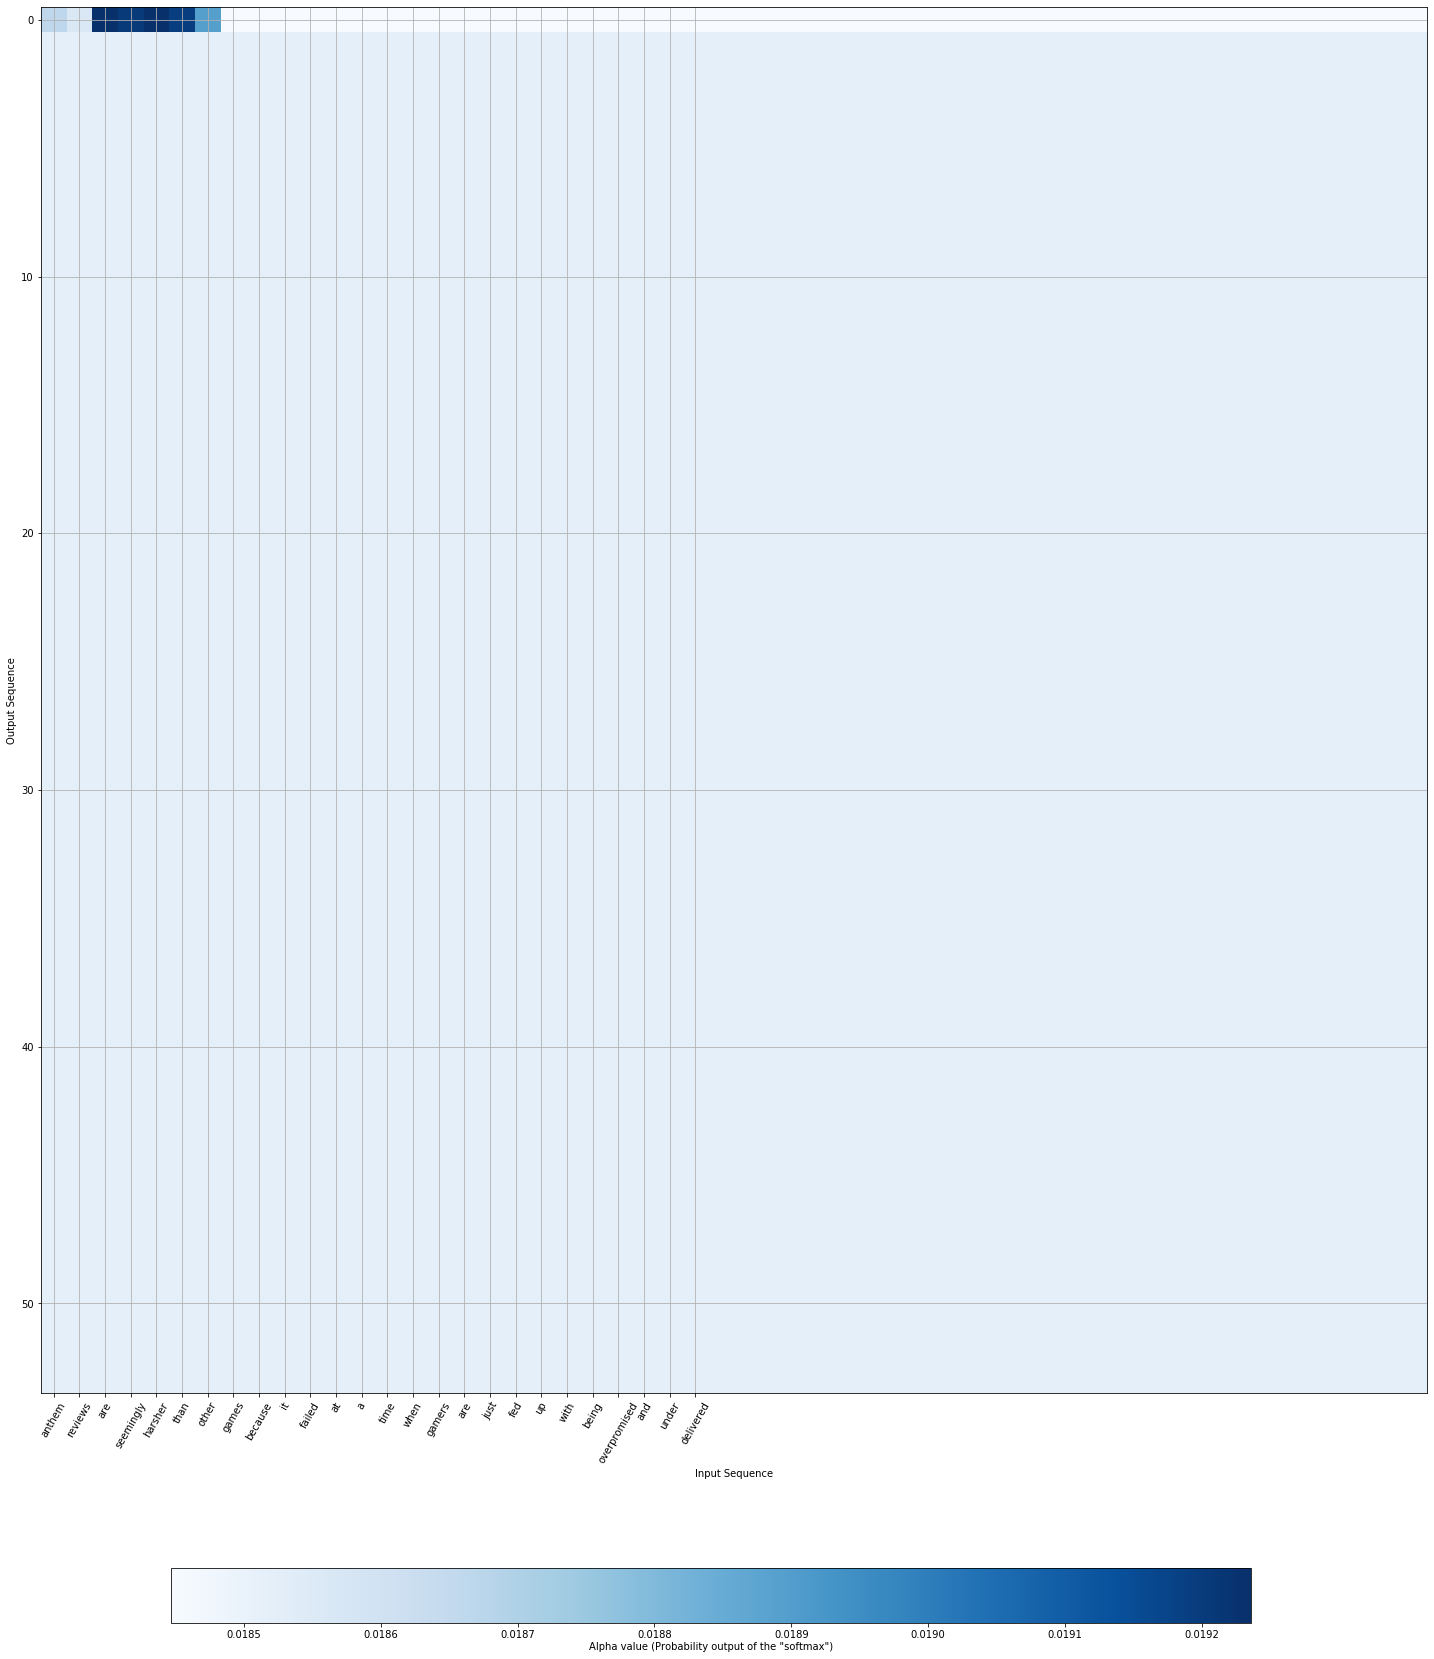

In [109]:
attention_map = plot_attention_map(model, X_test_indices[1].reshape(1,54), X_test[1], n_s = 128, num = 8, Tx = Tx)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("../models/model.json", "w") as json_file:
    print('works')
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../models/model.h5")
print("Saved model to disk")

In [ ]:
coreml_model = coremltools.converters.keras.convert(model)

In [ ]:
coreml_model.save('../models/CommentNetV2.mlmodel')

In [ ]:
print(coreml_model)

In [ ]:
Sisira Dabare